# Klasifikasi Citra Penyakit Pada Daun Mangga Menggunakan Metode Transfer Learning Dengan Model InceptionV3

Dataset yang digunakan adalah Mango Leaf Disease, datasetnya dapat di akses di: https://www.kaggle.com/datasets/aryashah2k/mango-leaf-disease-dataset

**Informasi Data:**

Jumlah gambar: 4000 gambar. Dari jumlah tersebut, sekitar 1800 memiliki daun yang berbeda, dan sisanya disiapkan dengan memperbesar dan memutar jika dianggap perlu.

Penyakit yang dipertimbangkan Tujuh penyakit yaitu Anthracnose, Bacterial Canker, Cutting Weevil, Die Back, Gall Midge, Powdery Mildew, and Sooty Mould.

Jumlah kelas : Delapan (termasuk kategori sehat).
Distribusi Kategori: Masing-masing dari delapan kategori berisi 500 gambar.

Bagaimana data diperoleh: Diambil dari pohon mangga melalui kamera ponsel.

Lokasi sumber data: Empat kebun mangga Bangladesh, yaitu kebun Universitas Pertanian Sher-e-Bangla, kebun Universitas Jahangir Nagar, kebun mangga desa Udaypur, dan kebun mangga desa Itakhola.

#**Download Data Kaggle di Google Collab Menggunakan Kaggle API**


Penjelasaan lengkapnya ada di: https://www.kaggle.com/discussions/general/74235

---
**Upload file Kaggle.json**



In [ ]:
from google.colab import files

files.upload()



---


**Mendownload Data**

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d aryashah2k/mango-leaf-disease-dataset

Dataset URL: https://www.kaggle.com/datasets/aryashah2k/mango-leaf-disease-dataset
License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)
 86% 89.0M/103M [00:00<00:00, 137MB/s]
100% 103M/103M [00:01<00:00, 108MB/s] 


# Preprocessing

Unzip dataset

In [ ]:
!unzip -d 'dataset' 'mango-leaf-disease-dataset.zip'

Archive:  mango-leaf-disease-dataset.zip
  inflating: dataset/Anthracnose/20211008_124249 (Custom).jpg  
  inflating: dataset/Anthracnose/20211008_124250 (Custom).jpg  
  inflating: dataset/Anthracnose/20211008_124252 (Custom).jpg  
  inflating: dataset/Anthracnose/20211008_124253 (Custom).jpg  
  inflating: dataset/Anthracnose/20211008_124256 (Custom).jpg  
  inflating: dataset/Anthracnose/20211008_124301 (Custom).jpg  
  inflating: dataset/Anthracnose/20211008_124302 (Custom).jpg  
  inflating: dataset/Anthracnose/20211008_124305 (Custom).jpg  
  inflating: dataset/Anthracnose/20211008_124306 (Custom).jpg  
  inflating: dataset/Anthracnose/20211008_124310 (Custom).jpg  
  inflating: dataset/Anthracnose/20211008_124312 (Custom).jpg  
  inflating: dataset/Anthracnose/20211008_124334 (Custom).jpg  
  inflating: dataset/Anthracnose/20211008_124336 (Custom).jpg  
  inflating: dataset/Anthracnose/20211008_124341 (Custom).jpg  
  inflating: dataset/Anthracnose/20211008_124345 (Custom).jpg  

Augmentasi Gambar dan Split Data menjadi 70:30

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

DATASET_DIR = '/content/dataset'

train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    channel_shift_range=10,
    horizontal_flip=True,
    fill_mode='nearest',
    rescale=1./255,
    validation_split=0.3,
)

test_datagen = ImageDataGenerator(rescale = 1/255.0, validation_split=0.3,)

train_generator = train_datagen.flow_from_directory(
    DATASET_DIR,
    target_size= (224,224),
    batch_size= 32,
    class_mode= 'sparse',
    subset='training'
)

test_generator = test_datagen.flow_from_directory(
    DATASET_DIR,
    target_size= (224,224),
    batch_size= 32,
    class_mode= 'sparse',
    subset='validation'
)

Found 2800 images belonging to 8 classes.
Found 1200 images belonging to 8 classes.


# Model

Menggunakan teknik transfer learning dari model InceptionV3

In [ ]:
from keras.applications.inception_v3 import InceptionV3

# Load model InceptionV3 yang telah dilatih sebelumnya dengan bobot yang telah dilatih sebelumnya di ImageNet
pre_trained_model = InceptionV3(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freeze lapisan yang telah dilatih sebelumnya
for layer in pre_trained_model.layers:
    layer.trainable=False

last_layer =  pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

87910968/87910968 [==============================] - 1s 0us/step


Menambahkan layer di bawah pre-trained model

In [ ]:
import tensorflow as tf

x = tf.keras.layers.Flatten() (last_output)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(8, activation='softmax')(x)

inception_model = tf.keras.Model(pre_trained_model.input, x)

inception_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 111, 111, 32)         0         ['batch_normalization[0]

Menentukan optimizer, loss dan metric.

In [ ]:
inception_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['acc'],
)

Membuat early stopping agar training berhenti jika sudah beberapa epoch tidak ada perubahan

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_acc',  # Monitor validation loss
    patience=5,          # Stop training setelah 5 epoch tanpa perubahan
    restore_best_weights=True,  # Memulihkan bobot dari epoch terbaik
)

membuat custom callback supaya bisa menhentikan training jika accuracy dan validation accuracy nya sudah diatas 95%

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs={}):
            if (logs.get('acc') > 0.95 and logs.get('val_acc') > 0.95):
                print("\naccuracy dan validation accuracy lebih tinggi dari 0.95 hentikan training!")
                self.model.stop_training = True

custom_callback = myCallback()

Training Model

In [ ]:
history = inception_model.fit(
    train_generator,
    epochs=25,
    validation_data= test_generator,
    callbacks=[custom_callback, early_stopping]
)

Epoch 1/25
88/88 [==============================] - 46s 479ms/step - loss: 1.8713 - acc: 0.6796 - val_loss: 0.4256 - val_acc: 0.8667
Epoch 2/25
88/88 [==============================] - 40s 453ms/step - loss: 0.3852 - acc: 0.8736 - val_loss: 0.4685 - val_acc: 0.8633
Epoch 3/25
88/88 [==============================] - 41s 465ms/step - loss: 0.2293 - acc: 0.9214 - val_loss: 0.3557 - val_acc: 0.9075
Epoch 4/25
88/88 [==============================] - 40s 456ms/step - loss: 0.1931 - acc: 0.9314 - val_loss: 0.5185 - val_acc: 0.8575
Epoch 5/25
88/88 [==============================] - 40s 448ms/step - loss: 0.1960 - acc: 0.9393 - val_loss: 0.3464 - val_acc: 0.8833
Epoch 6/25
88/88 [==============================] - 40s 457ms/step - loss: 0.1597 - acc: 0.9461 - val_loss: 0.3761 - val_acc: 0.8758
Epoch 7/25
88/88 [==============================] - 40s 452ms/step - loss: 0.1673 - acc: 0.9539 - val_loss: 0.3755 - val_acc: 0.8750
Epoch 8/25
88/88 [==============================] - 44s 506ms/step - 

# Evaluasi

Menujukan learning curve

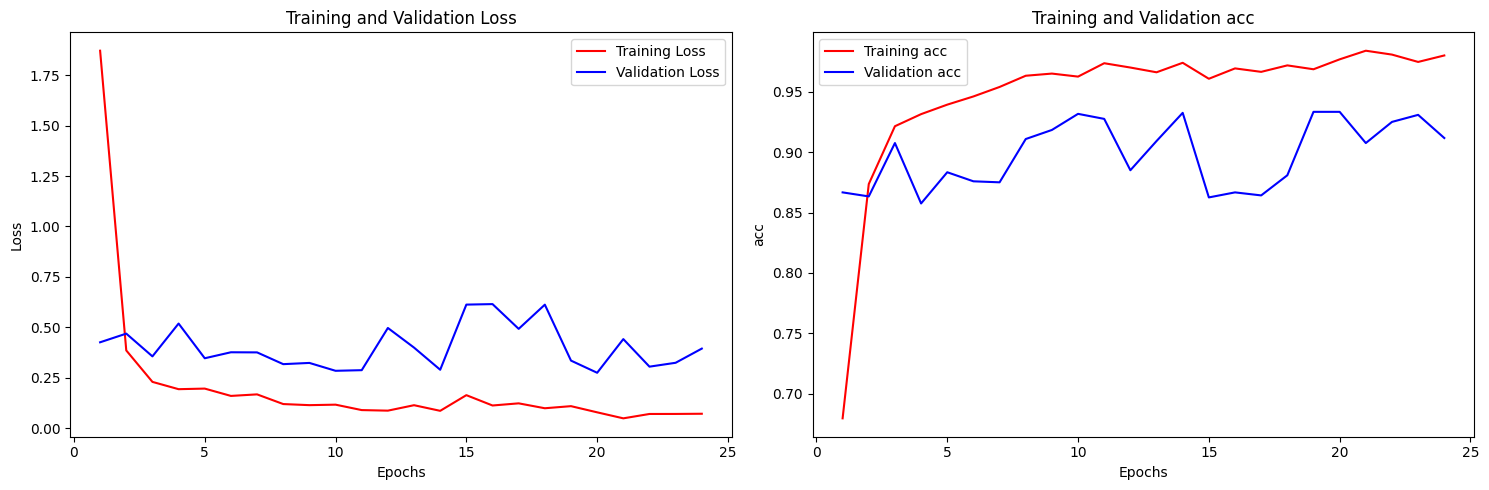

In [ ]:
import matplotlib.pyplot as plt

# mengakses training dan validation loss dan acc dari objek history
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['acc']
val_acc = history.history['val_acc']

# Set up plot untuk loss
plt.figure(figsize=(15, 5))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(range(1, len(loss) + 1), loss, 'r', label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, 'b', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Set up plot untuk acc
plt.subplot(1, 2, 2)
plt.plot(range(1, len(acc) + 1), acc, 'r', label='Training acc')
plt.plot(range(1, len(val_acc) + 1), val_acc, 'b', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('acc')
plt.title('Training and Validation acc')
plt.legend()

# Sesuaikan tata letak untuk mencegah overlapping
plt.tight_layout()

# Show the plot
plt.show()

Mempersiapkan data untuk evaluasi

In [ ]:
import numpy as np

# Inisialisasi variabel untuk menyimpan metriks
true_labels_all = []
predicted_labels_all = []
misclassified_data = []
predicted_probs_all = []

# Iterate di test generator
for i in range(len(test_generator)):
    # Get the next batch of data from the generator
    batch = test_generator[i]
    images = batch[0]
    true_labels_batch = batch[1]
    true_labels_all.extend(true_labels_batch)

    # Predict labels menggunakan model
    predictions_batch = inception_model.predict(images)
    predicted_probs_batch = predictions_batch
    predicted_probs_all.extend(predicted_probs_batch)
    probabilities_batch = np.max(predictions_batch, axis=1)
    predicted_labels_batch = np.argmax(predictions_batch, axis=1)
    predicted_labels_all.extend(predicted_labels_batch)

    # Check misclassified data di batch ini
    for j in range(len(true_labels_batch)):
        true_label = true_labels_batch[j]
        predicted_label = predicted_labels_batch[j]

        # jika predicted label berbeda dari true label, tambahkan ke misclassified_data
        if true_label != predicted_label:
            misclassified_data.append((images[j], true_label, predicted_label))

1/1 [==============================] - 1s 941ms/step


Menunjukan performa Accuracy, Precision, Recal, F1-Score dan AUC-ROC

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
import seaborn as sns

# Menghitung overall accuracy, precision, recall, F1-score
accuracy = accuracy_score(true_labels_all, predicted_labels_all)
precision = precision_score(true_labels_all, predicted_labels_all, average='weighted')
recall = recall_score(true_labels_all, predicted_labels_all, average='weighted')
f1_score_total = f1_score(true_labels_all, predicted_labels_all, average='weighted')
auc = roc_auc_score(true_labels_all, predicted_probs_all, multi_class='ovr')

# Print overall metrics
print("Overall Metrics:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score_total)
print("AUC-ROC:", auc)

Overall Metrics:
Accuracy: 0.9333333333333333
Precision: 0.93769840374479
Recall: 0.9333333333333333
F1-score: 0.9324502639948343
AUC-ROC: 0.9959833333333332


Menujukan Classification report

In [ ]:
class_labels = list(train_generator.class_indices.keys())
report = classification_report(true_labels_all, predicted_labels_all, target_names=class_labels)
print(report)

                  precision    recall  f1-score   support

     Anthracnose       0.99      0.75      0.86       150
Bacterial Canker       1.00      1.00      1.00       150
  Cutting Weevil       1.00      1.00      1.00       150
        Die Back       0.99      1.00      0.99       150
      Gall Midge       0.85      0.95      0.90       150
         Healthy       0.92      0.98      0.95       150
  Powdery Mildew       0.92      0.85      0.88       150
     Sooty Mould       0.84      0.93      0.88       150

        accuracy                           0.93      1200
       macro avg       0.94      0.93      0.93      1200
    weighted avg       0.94      0.93      0.93      1200



menunjukan Confusion Matrix

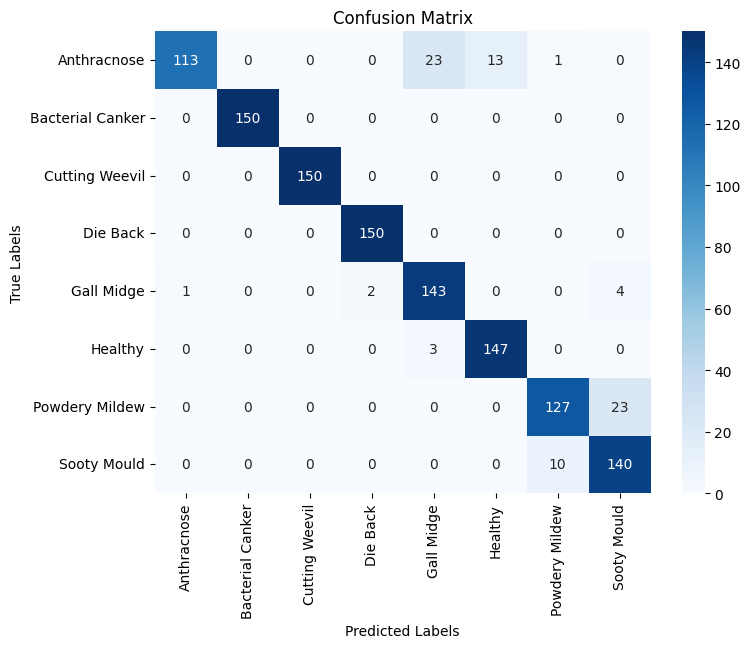

Total misclassified data: 80


In [ ]:
# Menghitung confusion matrix
conf_matrix = confusion_matrix(true_labels_all, predicted_labels_all)

# Plot confusion matrix menggunakan seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')  # Save the plot as an image
plt.show()

# Print total misclassified data
misclassified_count = len(misclassified_data)
print("Total misclassified data:", misclassified_count)

Performa model untuk data testing

In [ ]:
inception_model.evaluate(test_generator)

38/38 [==============================] - 3s 64ms/step - loss: 0.3347 - acc: 0.9333


[0.33474841713905334, 0.9333333373069763]

# Prediksi Gambar dengan upload file

Saving 20211231_123105 (Custom).jpg to 20211231_123105 (Custom).jpg


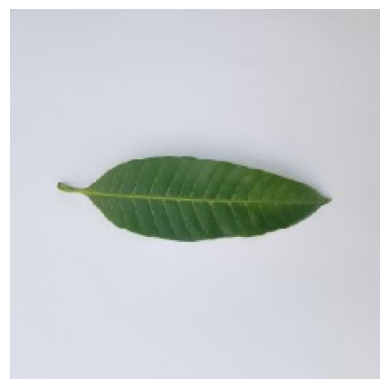

1/1 [==============================] - 0s 27ms/step
Predicted class: Healthy
Class probabilities: [1.0900540e-09 1.8445476e-13 5.0241616e-11 1.6608173e-11 1.8329595e-04
 9.9980432e-01 7.6174640e-12 1.2423265e-05]



In [ ]:
from keras.preprocessing.image import load_img, img_to_array

# Upload image
uploaded = files.upload()

for fn in uploaded.keys():
    # predicting images
    path = '/content/' + fn
    img = load_img(path, target_size=(224, 224))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    x = img_to_array(img)
    x /= 255.0
    x = np.expand_dims(x, axis=0)

    # Predict probabilities untuk setiap kelas
    probabilities = inception_model.predict(x)

    # Mendapatkan indeks kelas yang diprediksi (kelas dengan probabilitas tertinggi)
    predicted_class = np.argmax(probabilities)

    # Mendapatkan predicted class label
    predicted_class_label = class_labels[predicted_class]

    # Display hasil
    print(f"Predicted class: {predicted_class_label}")
    print("Class probabilities:", probabilities[0])
    print()